## We'll start by importing all of the necessary libraries.

In [1]:
from importlib import reload
# custom functions 
import helper_functions as hf

import sqlite3

import numpy as np
from numpy import std, mean, sqrt

import pandas as pd
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt

from statsmodels.stats.power import tt_ind_solve_power

from statsmodels.stats.multicomp import pairwise_tukeyhsd as Tukey
from statsmodels.stats.multicomp import MultiComparison as M_comp
np.random.seed(30)
reload(hf )

<module 'helper_functions' from 'C:\\Users\\Owner\\Desktop\\Data Science\\Flatiron_Projects\\mod-3-project\\helper_functions.py'>

### Setting up the connection to the database.

In [2]:
# Setting up the connection to the database
conn, cursor = hf.connection()

### looking at the table structure

In [3]:
hf.get_tables(cursor)

[('Employee',),
 ('Category',),
 ('Customer',),
 ('Shipper',),
 ('Supplier',),
 ('Order',),
 ('Product',),
 ('OrderDetail',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Region',),
 ('Territory',),
 ('EmployeeTerritory',)]

# Q1 - we are attempting to learn if discount amount has a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?

H0 - Discount does __NOT__ have a statistically significant effect on order quantity.<br>
HA - Discount __DOES__ have a statistically significant effect on order quantity.

- If H0 is rejected, the levels of significance will be investigated.

#### We will begin by retrieving the necessary data for our initial EDA.

In [4]:
df = hf.get_table(conn, table='OrderDetail')
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [ ]:
df.style()

In [5]:
df['Discount'].unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

#### We will separate out the discounted orders and non-discounted orders

In [6]:
df['discounted'] = [1 if d > 0 else 0 for d in df.Discount]
df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
0,10248/11,10248,11,14.0,12,0.0,0
1,10248/42,10248,42,9.8,10,0.0,0
2,10248/72,10248,72,34.8,5,0.0,0
3,10249/14,10249,14,18.6,9,0.0,0
4,10249/51,10249,51,42.4,40,0.0,0


In [7]:
disc_vals = df.loc[df.discounted > 0, 'Quantity']
non_disc_vals = df.loc[df.discounted == 0, 'Quantity']


In [8]:
disc_vals.head()

6     35
7     15
8      6
9     15
11    40
Name: Quantity, dtype: int64

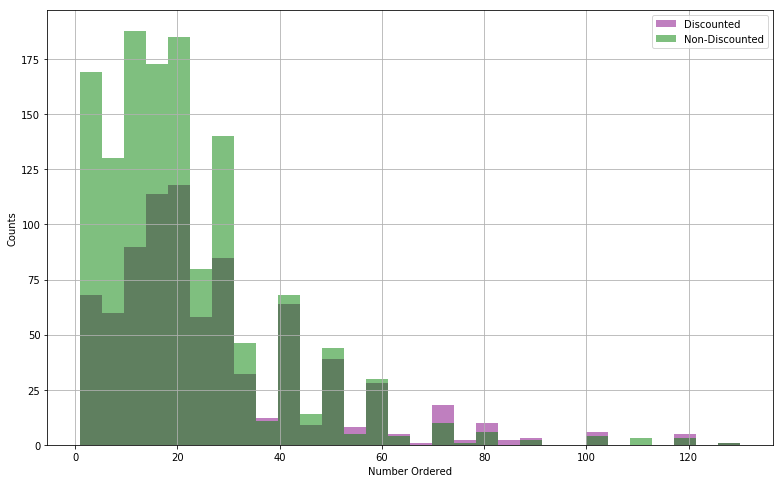

In [9]:
hf.get_hist(disc_vals, non_disc_vals, label1='Discounted', label2='Non-Discounted', gr_label_x='Number Ordered', gr_label_y='Counts')

Looking at the data, they appear to be very similar.<br>
Our assumptions are that the data is normal, and the variances are equal, so we will test our assumptions first<br>
- Using the Shapiro test for normality
- Using the Lavene test for equal variances

In [10]:
hf.test_equal_variance(disc_vals, non_disc_vals)
hf.test_normality(disc_vals)
hf.test_normality(non_disc_vals)

p= 0.00012091378376079568
 Variances are not equal.
p= 6.88120409395894e-26
 The data is not normally distributed.
p= 3.803856556577728e-34
 The data is not normally distributed.


False

Since the p-value of the Levene test for equal variances is less than .05, the variances are not equal.
Also, with the p-values of the Shapiro test above .05, this indicates that the data is not normally distributed.
We will perform a sampling distribution of the means to normalize it.

In [11]:
disc_sample_means = []
non_disc_sample_means = []
disc_sample_means, non_disc_sample_means = hf.sampling_means(data1=disc_vals, data2=non_disc_vals)

In [12]:
hf.test_normality(disc_sample_means)
hf.test_normality(non_disc_sample_means)
hf.test_equal_variance(disc_sample_means, non_disc_sample_means)

p= 0.6010640859603882
 The data is normally distributed.
p= 0.9130720496177673
 The data is normally distributed.
p= 0.018042947589795362
 Variances are not equal.


False

Let's plot the sample means to visualize the relationship now.

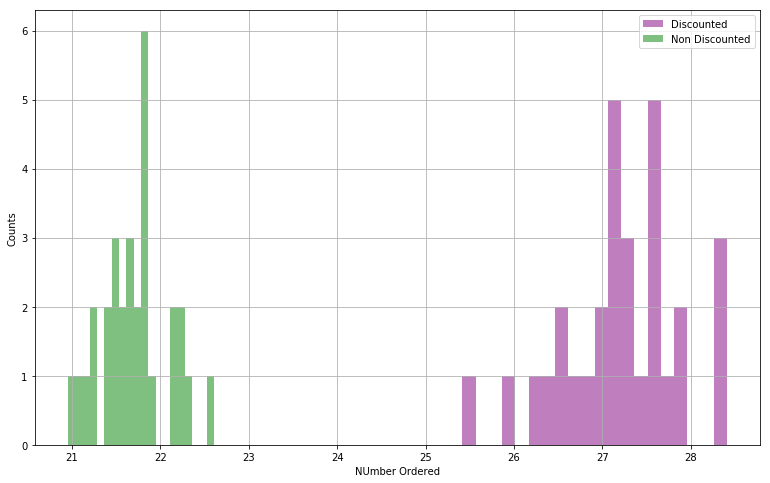

In [13]:
hf.get_hist(data1=disc_sample_means, data2=non_disc_sample_means, label1='Discounted', label2='Non Discounted', gr_label_x='NUmber Ordered', gr_label_y='Counts', bins=20)

#### It appears that we were successful in our attempt to get normally distributed data. 
Now we can begin to run tests on our hypothesis.
We will begin with a TTest
- H0 : µ1==µ2
- HA : µ1!-µ2


In [14]:
scs.ttest_ind(disc_sample_means, non_disc_sample_means)

Ttest_indResult(statistic=37.71787284813854, pvalue=1.67159617905503e-42)

With a p value of 0 we can conclude that our means are not equal, thus **rejecting our null hypothesis, H0**

We will test this using the mean and the sample standard deviation

In [15]:
disc_mean = np.mean(disc_sample_means)
disc_std = np.std(disc_sample_means, ddof=1)

non_disc_mean = np.mean(non_disc_sample_means)
non_disc_std = np.std(non_disc_sample_means, ddof=1)

In [16]:
samp_disc = np.random.normal(loc=disc_mean, scale=disc_std, size=100)
samp_non_disc = np.random.normal(loc=non_disc_mean, scale=non_disc_std, size=100)

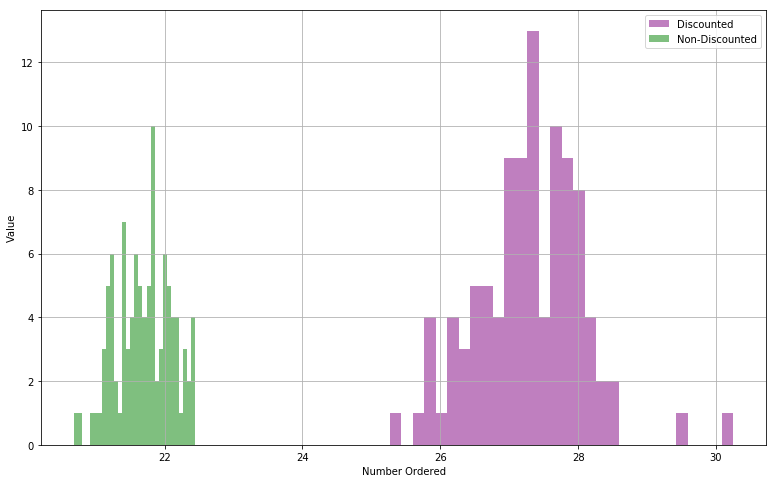

In [17]:
hf.get_hist(samp_disc, samp_non_disc, 'Discounted', 'Non-Discounted', 'Number Ordered', 'Value', bins=30)

### Clearly, from this graph we can see that discount has an effect on order quantity.
we will confirm this with a TTest.

In [18]:
scs.ttest_ind(disc_sample_means, non_disc_sample_means)

Ttest_indResult(statistic=37.71787284813854, pvalue=1.67159617905503e-42)

In [19]:
e_size = hf.calc_effect(disc_sample_means, non_disc_sample_means)
e_size

9.738712893013965

In [20]:
power = tt_ind_solve_power(effect_size=e_size, nobs1=100, alpha=0.05)
power

1.0

Given the above effect size we can __reject our null hypothesis, H0__ and proceed to investigate at which level discount is significant.

# Run tests on the data organized by discount level.
- Now we will investigate the different discount levels to see which is the most effective at driving up the order quantity.

for this part we will use the following hypotheses:
- H0 : µ1==µ2==µ3==µ4==µ5 - all of the means are equal and have equal effect
- HA : µ1!-µ2!=µ3!=µ4!=µ5 - at least one of the means has more effect than the others

First, we will drop the orders with no discount and the insignificant levels as well.

In [21]:

df2 = df
df2 = df2.drop(df2[(df2['Discount'] ==.00)].index)
df2 = df2.drop(df2[(df2['Discount'] ==.01)].index)
df2 = df2.drop(df2[(df2['Discount'] ==.02)].index)
df2 = df2.drop(df2[(df2['Discount'] ==.03)].index)
df2 = df2.drop(df2[(df2['Discount'] ==.04)].index)
df2 = df2.drop(df2[(df2['Discount'] ==.06)].index)
df2.head(10)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,discounted
6,10250/51,10250,51,42.4,35,0.15,1
7,10250/65,10250,65,16.8,15,0.15,1
8,10251/22,10251,22,16.8,6,0.05,1
9,10251/57,10251,57,15.6,15,0.05,1
11,10252/20,10252,20,64.8,40,0.05,1
12,10252/33,10252,33,2.0,25,0.05,1
17,10254/24,10254,24,3.6,15,0.15,1
18,10254/55,10254,55,19.2,21,0.15,1
29,10258/2,10258,2,15.2,50,0.20,1
30,10258/5,10258,5,17.0,65,0.20,1


Lets visualize the data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000210037A7E80>,
      dtype=object)

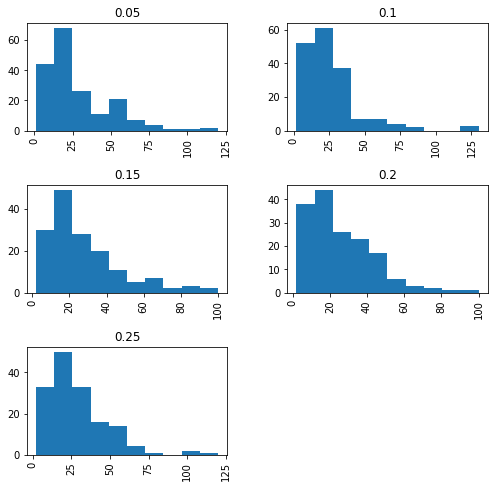

In [22]:
df2.hist('Quantity', by='Discount', figsize=(8,8))

From the graphs above, we can see that the data is normalish in each discount level, but skewed to the left.

Lets use the Shapiro test to see if the data is normal

In [23]:
disc_05 = df2.loc[df2.Discount == 0.05, 'Quantity']
disc_10 = df2.loc[df2.Discount == 0.1, 'Quantity']
disc_15 = df2.loc[df2.Discount == 0.15, 'Quantity']
disc_20 = df2.loc[df2.Discount == 0.2, 'Quantity']
disc_25 = df2.loc[df2.Discount == 0.25, 'Quantity']

hf.test_normality(disc_05)
hf.test_normality(disc_10)
hf.test_normality(disc_15)
hf.test_normality(disc_20)
hf.test_normality(disc_25)

p= 3.5543719660233175e-13
 The data is not normally distributed.
p= 4.159971249851485e-14
 The data is not normally distributed.
p= 8.372069704165597e-10
 The data is not normally distributed.
p= 3.249125413162801e-08
 The data is not normally distributed.
p= 2.6962121424389807e-09
 The data is not normally distributed.


False

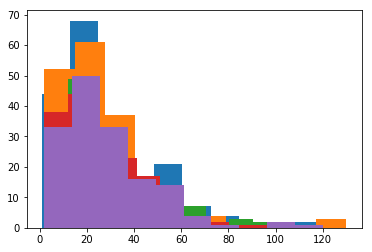

In [24]:
plt.hist(disc_05)
plt.hist(disc_10)
plt.hist(disc_15)
plt.hist(disc_20)
plt.hist(disc_25);

Since the data are not normally distributed, we will need to do some sampling to work with it.


In [25]:
disc_05mean = np.mean(disc_05)
disc_05std = np.std(disc_05, ddof=1)

samp_disc05 = np.random.normal(loc=disc_05mean, scale=disc_05std, size=100)

disc_10mean = np.mean(disc_10)
disc_10std = np.std(disc_10, ddof=1)

samp_disc10 = np.random.normal(loc=disc_10mean, scale=disc_10std, size=100)

disc_15mean = np.mean(disc_15)
disc_15std = np.std(disc_15, ddof=1)

samp_disc15 = np.random.normal(loc=disc_15mean, scale=disc_15std, size=100)

disc_20mean = np.mean(disc_20)
disc_20std = np.std(disc_20, ddof=1)

samp_disc20 = np.random.normal(loc=disc_20mean, scale=disc_20std, size=100)

disc_25mean = np.mean(disc_25)
disc_25std = np.std(disc_25, ddof=1)

samp_disc25 = np.random.normal(loc=disc_25mean, scale=disc_25std, size=100)

In [26]:
hf.test_normality(samp_disc05)
hf.test_normality(samp_disc10)
hf.test_normality(samp_disc15)
hf.test_normality(samp_disc20)
hf.test_normality(samp_disc25)

p= 0.645414412021637
 The data is normally distributed.
p= 0.9969398975372314
 The data is normally distributed.
p= 0.5766535997390747
 The data is normally distributed.
p= 0.01829749159514904
 The data is not normally distributed.
p= 0.5840601325035095
 The data is normally distributed.


True

C:\Users\Owner\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


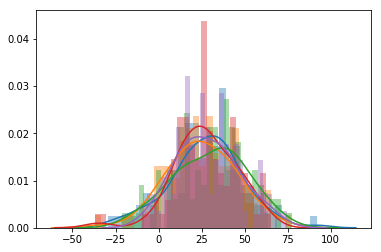

In [27]:
sns.distplot(samp_disc05, bins=30)
sns.distplot(samp_disc10, bins=30)
sns.distplot(samp_disc15, bins=30)
sns.distplot(samp_disc20, bins=30)
sns.distplot(samp_disc25, bins=30);

Now that our data is normally distributed, we will continue with our tests
Here we will test the effect of each discount against the non-discounted sample

In [28]:
print('.05')
e_05 = hf.calc_effect(samp_disc05, non_disc_sample_means)
print(e_05)
print('.10')
e_10 = hf.calc_effect(samp_disc10, non_disc_sample_means)
print(e_10)
print('.15')
e_15 = hf.calc_effect(samp_disc15, non_disc_sample_means)
print(e_15)
print('.20')
e_20 = hf.calc_effect(samp_disc20, non_disc_sample_means)
print(e_20)
print('.25')
e_25 = hf.calc_effect(samp_disc25, non_disc_sample_means)
print(e_25)

.05
0.3050093006985778
.10
0.18441023282181945
.15
0.43284339253042986
.20
0.3423464570908123
.25
0.41937241341359344


From these effect sizes, it looks like 20& is the most effective discount, with 15% close behind. 

In [29]:
power05 = tt_ind_solve_power(effect_size=e_05, nobs1=100, alpha=0.05)
print(power05)
power10 = tt_ind_solve_power(effect_size=e_10, nobs1=100, alpha=0.05)
print(power10)
power15 = tt_ind_solve_power(effect_size=e_15, nobs1=100, alpha=0.05)
print(power15)
power20 = tt_ind_solve_power(effect_size=e_20, nobs1=100, alpha=0.05)
print(power20)
power25 = tt_ind_solve_power(effect_size=e_25, nobs1=100, alpha=0.05)
print(power25)

0.5739187524973286
0.25444883390739653
0.8612215230036058
0.6733032584591414
0.8391658720416506


#### Conclusion:
- As a result of the analysis, we can __REJECT the null H0__<br>
- The discount level that shows the most effect is 20%, but with 15% almost equally as effective, it would make sense to use a discount of 15% since it would have the same increase on quantity and reduce the profit least between the two discount levels.

#### Recommendations:
- the company should drop all discounts below 10%
- The company should offer discount of 15% on products that increased quantity sold is desired.